In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

import milopy.core as milo
import milopy.plot as milopl

In [3]:
input_file="./CTCL/objects/APC_allgenes.h5ad"
adata = sc.read_h5ad(input_file)

In [39]:
adata

AnnData object with n_obs × n_vars = 128262 × 15777
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'sample_type', 'cell_type', 'Condition', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'neighbors', 'sample_type_colors', 'scvi', 'nhood_neighbors_key', 'nhood_adata'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs', 'nhoods'
    obsp: 'connectivities', 'distances', 'scvi_distances', 'scvi_connectivities'

In [5]:
adata.X.expm1().sum(axis = 1)

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/scipy/sparse/data.py:133: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


matrix([[            inf],
        [            inf],
        [5.57991031e+186],
        ...,
        [2.75851345e+033],
        [1.73927494e+018],
        [1.62183053e+005]])

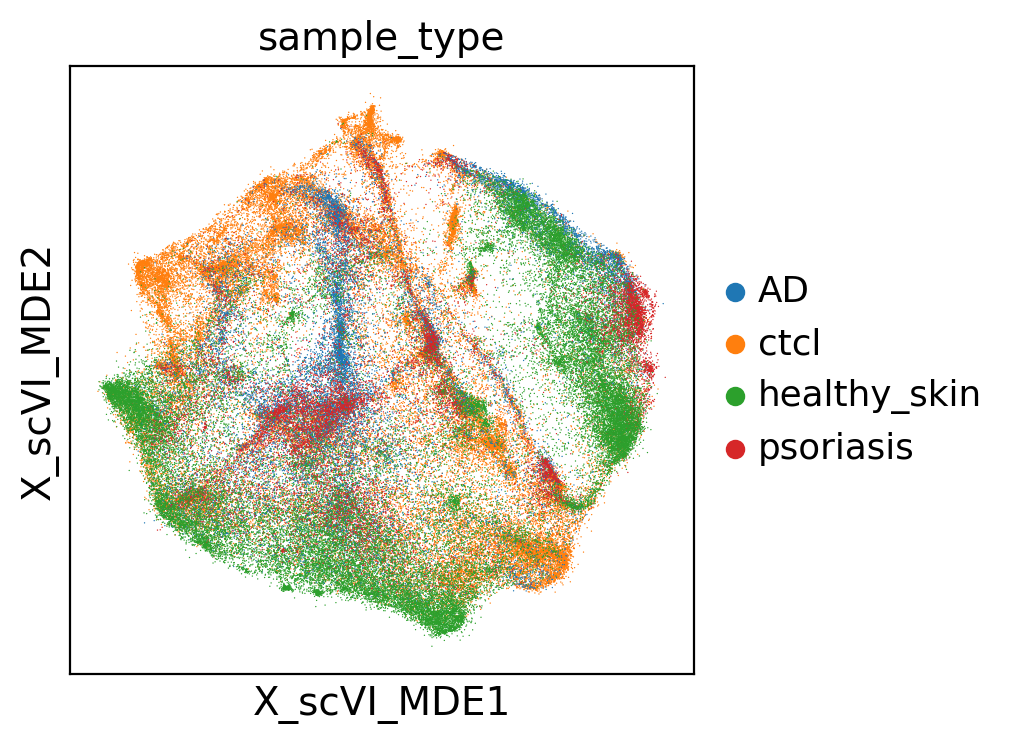

In [14]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.embedding(adata, color=['sample_type'], basis = 'X_scVI_MDE')

In [6]:
adata.obs['sample_type'].value_counts()

ctcl            50304
healthy_skin    44646
AD              18690
psoriasis       14622
Name: sample_type, dtype: int64

In [7]:
adata.obs['Condition'] = "a_Other"
ll = adata.obs['sample_type'] == 'ctcl'
adata.obs.loc[ll, 'Condition'] = 'CTCL'

In [8]:
adata.obs['Condition'].value_counts()

a_Other    77958
CTCL       50304
Name: Condition, dtype: int64

In [9]:
adata

AnnData object with n_obs × n_vars = 128262 × 15777
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'sample_type', 'cell_type', 'Condition'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'hvg', 'neighbors', 'sample_type_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    obsp: 'connectivities', 'distances'

In [10]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 100, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

computing neighbors


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['scvi']`
    `.obsp['scvi_distances']`, distances for each pair of neighbors
    `.obsp['scvi_connectivities']`, weighted adjacency matrix (0:01:37)


In [11]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
ACGCCAGGTTATCCGA-0_CTCL1_CTCL1_CTCL1,1,1.375774
CATCAGAAGTGTGGCA-0_CTCL1_CTCL1_CTCL1,1,1.185031
CATGCCTGTCGGATCC-0_CTCL1_CTCL1_CTCL1,1,0.935079
CCCTCCTTCGGCCGAT-0_CTCL1_CTCL1_CTCL1,1,1.068769
CCGGGATAGAGTGACC-0_CTCL1_CTCL1_CTCL1,1,1.393121
...,...,...
GGTGAAGAGCGGCTTC-91_S5,1,1.342170
GGTATTGTCTGACCTC-92_S5,1,1.438960
CAGATCAGTTAAAGAC-92_S5,1,1.162665
CATTATCCAACTGGCC-92_S5,1,1.184662


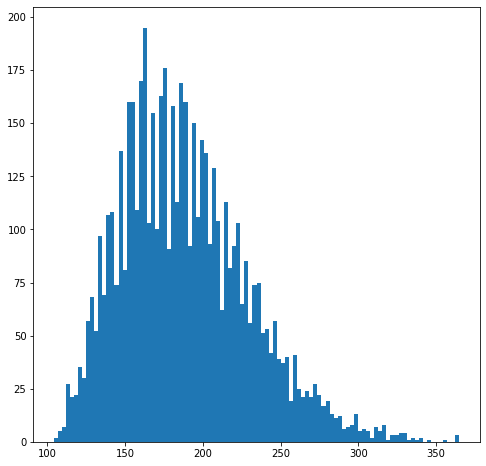

In [12]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [13]:
milo.count_nhoods(adata, sample_col="donor")

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/milopy/core.py:157: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  nhood_adata = anndata.AnnData(X=nhood_count_mat, var=nhood_var)


In [14]:
milo.DA_nhoods(adata, design="~Condition")

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:2085: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)


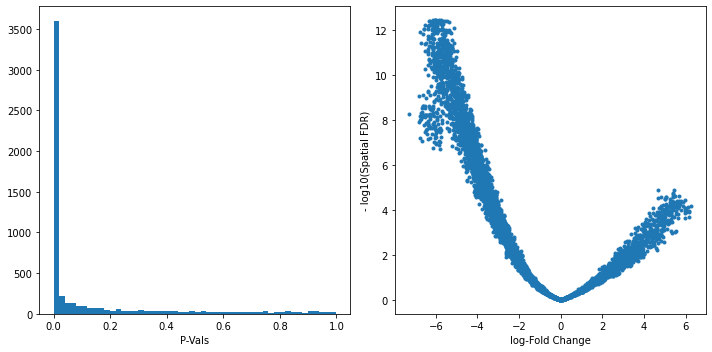

In [15]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [16]:
import milopy.utils
milopy.utils.build_nhood_graph(adata, basis = 'X_scVI_MDE')

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


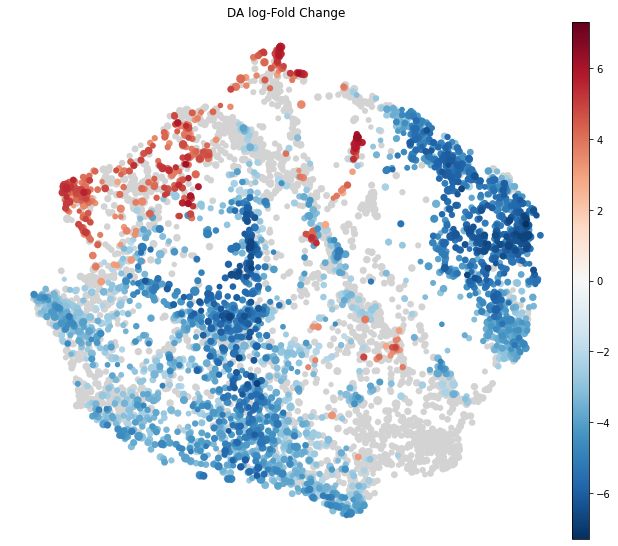

In [17]:
plt.rcParams["figure.figsize"] = [11,9.5]
milopl.plot_nhood_graph(adata, 
                        alpha=0.01, ## SpatialFDR level (1%) 
                        min_size=1, ## Size of smallest dot\
                        plot_edges = False)

In [18]:
milopy.utils.annotate_nhoods(adata, anno_col='cell_type')

Text(0.5, 0, 'celltype fraction')

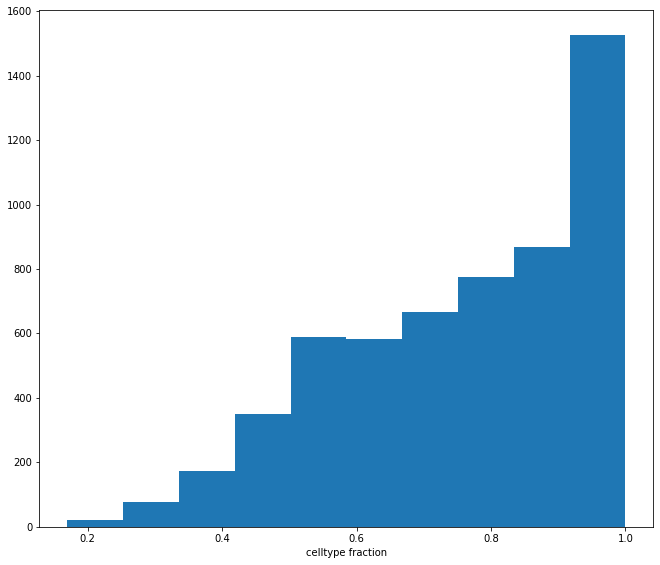

In [19]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [50]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.8, "nhood_annotation"] = "Mixed"

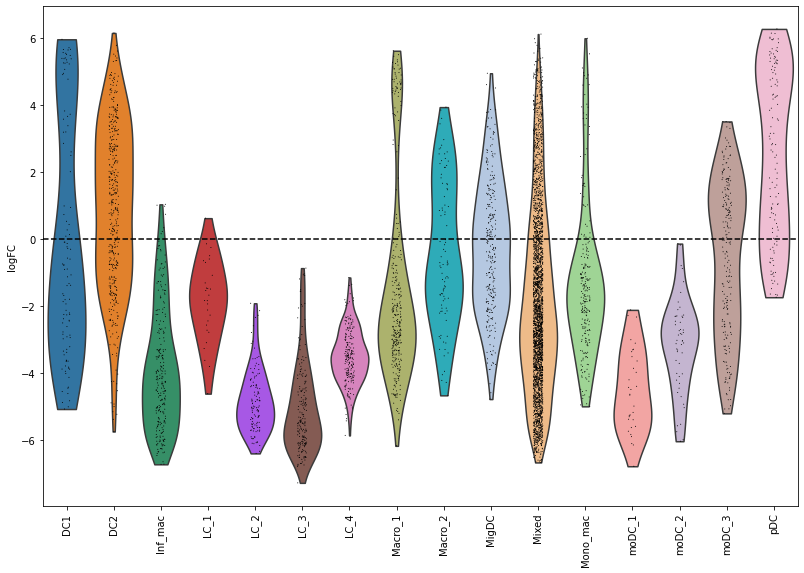

In [51]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

In [52]:
adata.uns["nhood_adata"].obs.to_csv('nhood_milo_APC_20240711.csv')

In [63]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [64]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [55]:
%%R
library(miloR)
library(igraph)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

In [56]:
%%R 
DA_results <- read.csv('nhood_milo_APC_20240711.csv')
DA_results$Nhood <- DA_results$Nhood+1
DA_results %>% head

  X                           index_cell kth_distance        logFC   logCPM
1 0 ACGCCAGGTTATCCGA-0_CTCL1_CTCL1_CTCL1    1.3757739  0.223039438 8.974455
2 1 CATCAGAAGTGTGGCA-0_CTCL1_CTCL1_CTCL1    1.1850314  1.457314522 9.559901
3 2 CATGCCTGTCGGATCC-0_CTCL1_CTCL1_CTCL1    0.9350793 -3.396565990 8.784613
4 3 CCCTCCTTCGGCCGAT-0_CTCL1_CTCL1_CTCL1    1.0687687 -0.009995908 9.072033
5 4 CCGGGATAGAGTGACC-0_CTCL1_CTCL1_CTCL1    1.3931214 -1.226463622 9.353502
6 5 CCTTCCCAGCGGCTTC-0_CTCL1_CTCL1_CTCL1    0.9705902 -2.632875850 8.931791
             F       PValue          FDR   SpatialFDR Nhood_size
1 6.034343e-02 8.066164e-01 8.416021e-01 8.398948e-01        160
2 2.134999e+00 1.480914e-01 1.907192e-01 1.883107e-01        189
3 2.023321e+01 2.424302e-05 7.133505e-05 6.832264e-05        221
4 1.159875e-04 9.914354e-01 9.933766e-01 9.933751e-01        179
5 2.199170e+00 1.421915e-01 1.841685e-01 1.818102e-01        206
6 1.041126e+01 1.849020e-03 3.620220e-03 3.494000e-03        210
  nhood_annot

In [57]:
%%R 
DA_results_filter <- DA_results[DA_results$SpatialFDR < 0.01,]
DA_results_filter %>% head

    X                           index_cell kth_distance     logFC   logCPM
3   2 CATGCCTGTCGGATCC-0_CTCL1_CTCL1_CTCL1    0.9350793 -3.396566 8.784613
6   5 CCTTCCCAGCGGCTTC-0_CTCL1_CTCL1_CTCL1    0.9705902 -2.632876 8.931791
8   7 CTCTACGAGCGTGAAC-0_CTCL1_CTCL1_CTCL1    0.8974659 -2.953780 9.020594
13 12 GTTCTCGCAATGGATA-0_CTCL1_CTCL1_CTCL1    1.0944992 -2.328408 8.681184
19 18 ACGATACAGCACAGGT-2_CTCL1_CTCL1_CTCL1    1.2446581 -3.077609 8.832505
35 34 CGAGCACCAAGGTGTG-5_CTCL5_CTCL5_CTCL5    1.4692268 -2.100335 8.914388
           F       PValue          FDR   SpatialFDR Nhood_size nhood_annotation
3  20.233214 2.424302e-05 7.133505e-05 6.832264e-05        221             LC_4
6  10.411260 1.849020e-03 3.620220e-03 3.494000e-03        210             LC_4
8  12.899685 5.805124e-04 1.259566e-03 1.211608e-03        277             LC_4
13  9.088476 3.495566e-03 6.432344e-03 6.230630e-03        157             LC_4
19 21.586832 1.380083e-05 4.306257e-05 4.133723e-05        155            M

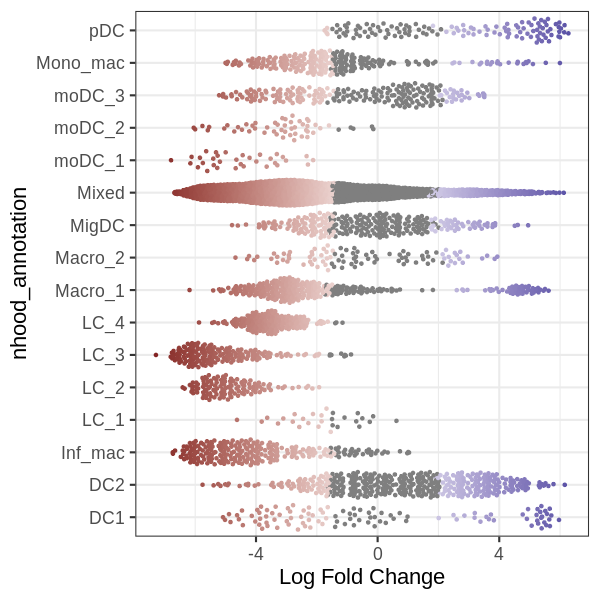

In [58]:
%%R -w 600 -h 600
plotDAbeeswarm(DA_results, group.by = "nhood_annotation")

In [71]:
%%R -w 800 -h 900 
library(ggplot2)

DA_results_filter <- DA_results[DA_results$nhood_annotation != 'Mixed', ]

plotDAbeeswarm(DA_results_filter, group.by = "nhood_annotation") + 
    theme(legend.position = "none") +
    #theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    geom_hline(yintercept=0, linetype=2, color="black")+
    scale_colour_gradient2(low = scales::muted("blue"), mid = "white",
                           high = scales::muted("red"))

ggsave("./figures/milo_APC.pdf", width = 10.5, height = 12.5)
### "cell_states" represents pre-defined/pre-annotated cell clusters

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
